In [1]:
from __future__ import print_function
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import argparse
import unet2d
import pandas as pd
import SimpleITK as sitk
import scipy.ndimage
import matplotlib.pyplot as plt
import scipy.stats
import imageio

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--input_dir', type=str, default='/raid/COVID-19/CT-severity/processed/dataset/')
parser.add_argument('--exclude', type=str, default='Iran_1,korea,Italy,all_results,medseg_1')

parser.add_argument('--restore_dir', type=str, 
                    default='/raid/COVID-19/CT-severity/results/Iran-2020-04-01-with-annotation/unet2d_256x256x7_mask/em/bias_-9_scale_0.5/')
parser.add_argument('--checkpoint', type=str, default='49')

parser.add_argument('--device', type=str, default='0')
parser.add_argument('--batch_size', type=int, default=16)

net = unet2d.unet2d()
parser = net.add_to_parser(parser)

In [3]:
if sys.argv[0] != 'test_mseg.py':
    args = parser.parse_args(['--device', '3', '--n_class', '3'])
else:
    args = parser.parse_args()

for k in vars(args):
    print (k, '=', vars(args)[k])

layers = 5
fc_nodes = [1024]
finetune_scope = finetune
filter_size = 3
input_dir = /raid/COVID-19/CT-severity/processed/dataset/
keep_prob = 1.0
n_class = 3
dice_smooth = 1
batch_size = 16
input_shape = [256, 256, 7]
checkpoint = 49
up_layers = 0
exclude = Iran_1,korea,Italy,all_results,medseg_1
device = 3
restore_dir = /raid/COVID-19/CT-severity/results/Iran-2020-04-01-with-annotation/unet2d_256x256x7_mask/em/bias_-9_scale_0.5/
pool_size = 2
fc_drop = [0.25]
features_root = 32


In [4]:
# build network
os.environ['CUDA_VISIBLE_DEVICES'] = args.device
tf.reset_default_graph()
model = unet2d.unet2d()
model.from_args(args)
model.build_unet_mask()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
# restore
loader = tf.train.Saver()
loader.restore(sess, os.path.join(args.restore_dir, args.checkpoint))



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /raid/COVID-19/CT-severity/results/Iran-2020-04-01-with-annotation/unet2d_256x256x7_mask/em/bias_-9_scale_0.5/49


In [5]:
def load_dataset(input_dir, cohort, exclude_set = []):
    inds = [int(os.path.basename(s)[:-len('.npz')]) for s in glob.glob(os.path.join(input_dir, '*.npz'))]
    inds = [d for d in inds if d not in exclude_set]
    
    if len(inds) == 0:
        return None
    
    dataset = {}
    for index in inds:
        f = np.load(os.path.join(input_dir, '%d.npz'%index))
        for k in f:
            if k not in dataset:
                dataset[k] = []
            dataset[k].append(f[k])
    
    for k in dataset:
        dataset[k] = np.concatenate(dataset[k])
    dataset['cohort'] = np.array([cohort] * len(dataset[dataset.keys()[0]]))
    
    return dataset

In [6]:
# get studying cohorts
exclude_cohort = args.exclude.split(',')
print (exclude_cohort)
cohorts = [os.path.basename(s) for s in glob.glob(os.path.join(args.input_dir, '*')) if os.path.basename(s) not in exclude_cohort and os.path.isdir(s)]
print (cohorts)

['Iran_1', 'korea', 'Italy', 'all_results', 'medseg_1']
['Iran_2', 'mgh', 'korea_all', 'Italy_all']


In [7]:
# loading data
data_list = []
for cohort in cohorts:
    print ('loading %s'%cohort)
    d = load_dataset(os.path.join(args.input_dir, cohort, 'npzs', 'with_unet_pred'), cohort)
    if d is not None:
        data_list.append(d)
dataset = {}
for k in data_list[0]:
    dataset[k] = np.concatenate([d[k] for d in data_list])

loading Iran_2
loading mgh
loading korea_all
loading Italy_all


In [8]:
# load patient information
patient_infos = {}
for cohort in cohorts:
    if os.path.exists(os.path.join(args.input_dir, cohort, 'patient_types.npy')):
        info = np.load(os.path.join(args.input_dir, cohort, 'patient_types.npy'), allow_pickle=True).item()
        for k in info:
            info[k]['cohort'] = cohort
        patient_infos.update(info)

# load exclusion
df = []
for cohort in cohorts:
    if os.path.exists(os.path.join(args.input_dir, cohort, 'mrn_train.csv')):
        df.append(pd.read_csv(os.path.join(args.input_dir, cohort, 'mrn_train.csv')))
if len(df) == 0:
    mrn_to_exclude = []
else:
    mrn_to_exclude = list(pd.concat(df, ignore_index=True).filename)
print (mrn_to_exclude)

['10932430_E15476328_3', '11390592_E15476611_3', '13523289_5', '16100674_2', '21533379_4', '27797874_5', '27815633_5']


In [9]:
def get_patient_data_mrn(mrn, dataset, patient_infos):
    patient = {}
    
    inds = np.where(dataset['mrns'] == mrn)[0]
    
    for k in dataset:
        patient[k] = dataset[k][inds]
    if mrn in patient_infos:
        patient['info'] = patient_infos[mrn]
    else:
        patient['info'] = None
        
    return patient

In [10]:
# predict all
preds = []
imgs = dataset['img']
masks = np.where(dataset['pred'] > 0.5, 1, 0)
print (imgs.shape[0])
for ibatch in range(0, imgs.shape[0], args.batch_size):
    if (ibatch // args.batch_size + 1) % 10 == 0:
        print (ibatch, end=',')
    batch_x = imgs[ibatch:ibatch+args.batch_size]
    batch_mask = masks[ibatch:ibatch+args.batch_size]
    pred = sess.run(model.pred, {model.X: batch_x, model.mask: batch_mask, model.phase: 0})

    preds.append(pred)
print ('concatenating pred')
preds = np.concatenate(preds)

dataset['pred_type'] = np.where(preds > 0.5, 1, 0)
dataset['pred_type'] += masks

7212
144,304,464,624,784,944,1104,1264,1424,1584,1744,1904,2064,2224,2384,2544,2704,2864,3024,3184,3344,3504,3664,3824,3984,4144,4304,4464,4624,4784,4944,5104,5264,5424,5584,5744,5904,6064,6224,6384,6544,6704,6864,7024,7184,concatenating pred


In [11]:
# reformat to images
mrn_unique = np.unique(dataset['mrns'])

In [12]:
# calculate consolidation vs. ggo for groups with consolidation (2,3) and without
frac_cons_th = []
frac_cons = []
pred_severity = []
severity = []
has_cons = []
dices = []

print (len(mrn_unique))
for k, mrn in enumerate(mrn_unique):
    if (k+1) % 10 == 0:
        print (k, end=',')
    
    patient = get_patient_data_mrn(mrn, dataset, patient_infos)
    
    mask_area = float(patient['pred'].sum())
    lung_area = float(patient['lung'].sum())

    cons_area = np.count_nonzero(patient['pred_type'] == 2)
    frac_cons.append(cons_area / lung_area)
    
    masked_pred = patient['img'][...,[3]] * patient['pred']
    frac_cons_th.append(np.count_nonzero(masked_pred > (1024 - 200) / 110.0) / lung_area)
    
    label = patient['label']
    pred = patient['pred']
    
    dice = 2 * np.sum(label * pred) / (np.sum(label) + np.sum(pred) + 1e-4)
    dices.append(dice)
    
    pred_severity.append(mask_area / lung_area)
    severity.append(label.sum() / lung_area)
    
    if patient['info'] is not None:
        if mrn in mrn_to_exclude:
            has_cons.append(-1)
        elif 2 in patient['info']['all_types'] or 3 in patient['info']['all_types']:
            has_cons.append(1)
#         elif 1 in patient['info']['all_types'] and len(np.unique(patient['info']['all_types'])) == 1:
#             has_cons.append(0)
        else:
            has_cons.append(0)
    else:
        has_cons.append(-1)
dices = np.array(dices)
frac_cons_th = np.array(frac_cons_th)
frac_cons = np.array(frac_cons)
severity = np.array(severity)
pred_severity = np.array(pred_severity)
has_cons = np.array(has_cons)

145
9,19,29,39,49,59,69,79,89,99,109,119,129,139,

62
0.6322862386409845 0.173879210877237
0.6816393477881113
(0.8256145273601422, 1.5088461810478212e-16)


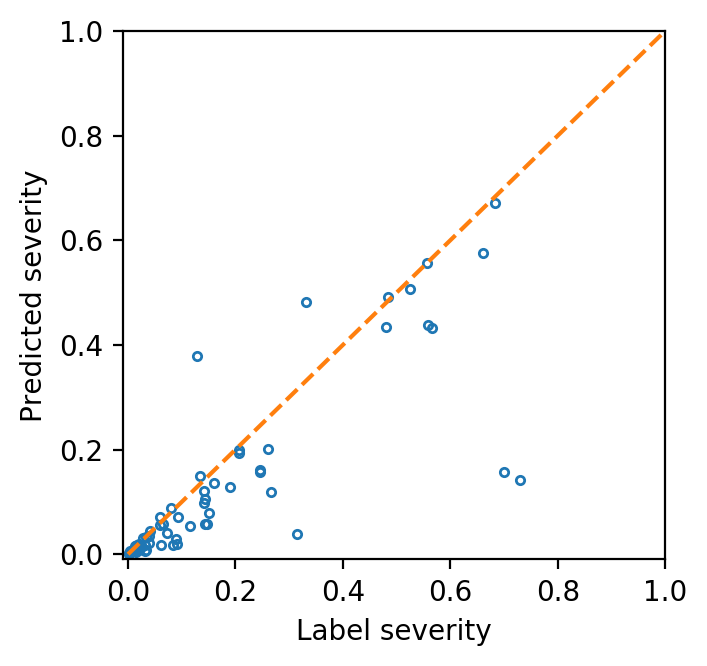

In [45]:
inds = np.where(severity > 1e-6)[0]
inds = [i for i in inds if mrn_unique[i] not in mrn_to_exclude]
plt.figure(figsize = [3.5,3.5], dpi=200)
plt.plot(severity[inds], pred_severity[inds], 'o', markersize=3, fillstyle='none')
plt.xlabel('Label severity')
plt.ylabel('Predicted severity')
plt.xlim([-0.01,1])
plt.ylim([-0.01,1])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(severity[inds], pred_severity[inds])
plt.plot([0,1], [0,1], '--')
# plt.xlim([0, 0.1])
# plt.ylim([0, 0.1])
# plt.yticks([0,0.05,0.1])
print (len(inds))
print (np.mean(dices[inds]), np.std(dices[inds]))
print (r_value**2)
print (scipy.stats.pearsonr(severity[inds], pred_severity[inds]))

In [14]:
import itertools

# classification accuracy
def get_discrete_severity(severity, thresholds):
    thresholds = np.sort(thresholds)
    label = np.zeros_like(severity)
    label[severity > thresholds[-1]] = len(thresholds)
    for k in range(len(thresholds)-1, -1, -1):
        label[severity <= thresholds[k]] = k
    return label.astype(int)

# confusion matrix
# confusion matrix
def CalcConfusionMatrix2(labels, preds, nClasses = 5):
    cm = np.zeros([nClasses, nClasses], int)
    
    for i in range(labels.shape[0]):
        cm[preds[i], labels[i]] += 1
    
    return cm

def plot_confusion_matrix(cm, class_names, title = 'Confusion matrix', 
                          ylabel = 'Prediction', xlabel = 'Label', normalized = True,
                          figsize = (6,6), dpi=200):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    if normalized:
        cm = np.around(cm.astype('float') / cm.sum(), decimals=2)
#     cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i+0.15, '%d\n(%.2f)'%(cm[i, j], cm[i, j].astype('float') / cm.sum()), horizontalalignment="center", color=color)

#     plt.tight_layout()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    return figure

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = imageio.imread(buf)
    # Add the batch dimension
    
    return image[np.newaxis, ...]

0.7903225806451613


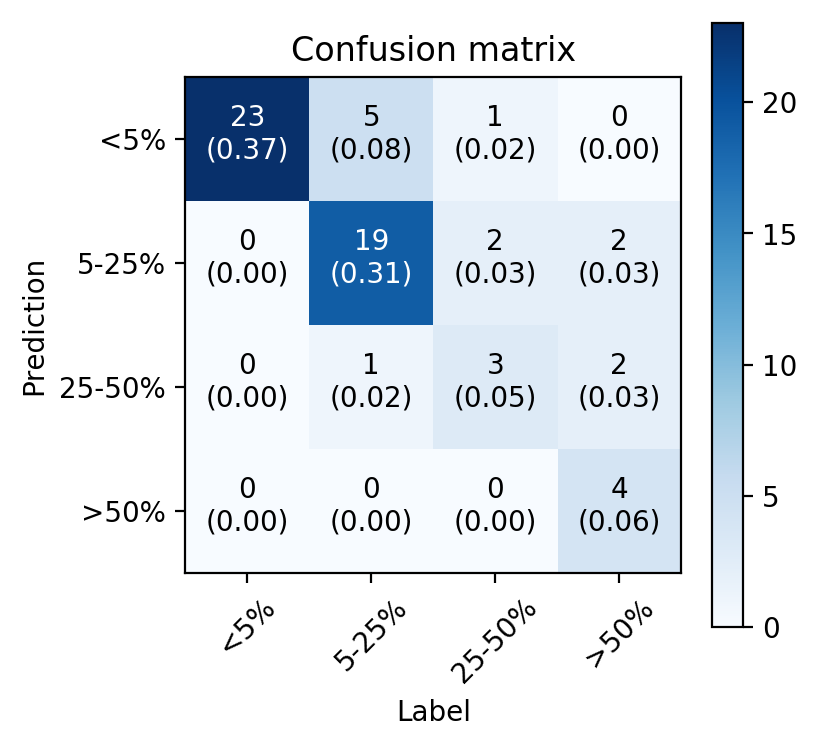

In [21]:
thresholds = [0.05, 0.25, 0.5]
discrete_label = get_discrete_severity(severity[inds], thresholds)
discrete_pred = get_discrete_severity(pred_severity[inds], thresholds)
cm = CalcConfusionMatrix2(discrete_label, discrete_pred, len(thresholds) + 1)
accuracy = np.sum(np.diag(cm)) / np.sum(cm, dtype=np.float32)
print (accuracy)
cm_img = plot_confusion_matrix(cm, ['<5%', '5-25%', '25-50%', '>50%'], normalized =False, figsize = (4,4),dpi=200)

In [22]:
# inds2 = np.where(discrete_label - discrete_pred > 1)
# print (inds[inds2])
# t = [m for m in mrn_unique[inds] if get_patient_data_mrn(m, dataset, patient_infos)['info']['cohort'] == 'korea_all']
# print (len(t))

In [23]:
df = pd.DataFrame({
    'mrn': mrn_unique,
    'consolidation': has_cons,
    'frac_cons': frac_cons, 
    'frac_cons_th': frac_cons_th, 
    'pred_severity': pred_severity,
    'severity': severity
})
df.to_csv(os.path.join(args.input_dir, 'cons_score.csv'), index=False)

In [24]:
df.sort_values(by='mrn').reset_index()

,index,consolidation,frac_cons,frac_cons_th,mrn,pred_severity,severity
0,0,1,0.000113,0.001706,02619963_E15389065_3,1.422597e-01,0.729163
1,1,0,0.005676,0.010336,0631027_E15457491_4,1.565519e-01,0.700660
2,2,1,0.225417,0.192552,07079569_E15489220_9,4.910489e-01,0.483709
3,3,0,0.000976,0.001587,0795617_E14877702_302,3.012425e-02,0.027118
4,4,0,0.007740,0.015813,08077661_E15479449_9,1.610153e-01,0.245827
5,5,1,0.009370,0.007622,10033545_2,1.201542e-01,0.141413
6,6,1,0.009691,0.009853,10421937_2,5.550488e-02,0.059056
7,7,1,0.000119,0.000048,10876296_2,7.678759e-04,0.000839
8,8,-1,0.092143,0.033968,10932430_E15476328_3,2.865954e-01,0.295678
9,9,0,0.067343,0.056165,10_201,3.797413e-01,0.129205


In [25]:
df_over = df[(df.consolidation == 1) & (df.frac_cons > 0.05) & (df.severity > 0.0001)]
df_over

,consolidation,frac_cons,frac_cons_th,mrn,pred_severity,severity
2,1,0.225417,0.192552,07079569_E15489220_9,0.491049,0.483709
16,1,0.098838,0.068596,12311731_2,0.507576,0.524625
57,1,0.085801,0.055998,20652284_2,0.200639,0.260876
66,1,0.106847,0.077252,22082742_2,0.555668,0.557057
138,1,0.184311,0.135645,41940826_E15490349_5,0.432833,0.565679
141,1,0.140576,0.110467,6026796_E15477693_14,0.575858,0.661298
144,1,0.200207,0.121433,9_201,0.482652,0.331185


In [26]:
df[(df.consolidation == 0) & (df.frac_cons > 0.05)]

,consolidation,frac_cons,frac_cons_th,mrn,pred_severity,severity
9,0,0.067343,0.056165,10_201,0.379741,0.129205
40,0,0.061363,0.046908,1614668_3,0.193631,0.206963


In [46]:
df[(df.severity > 0.6) & (df.pred_severity < 0.3)]

,consolidation,frac_cons,frac_cons_th,mrn,pred_severity,severity
0,1,0.000113,0.001706,02619963_E15389065_3,0.142260,0.729163
1,0,0.005676,0.010336,0631027_E15457491_4,0.156552,0.700660


In [27]:
# has_cons[[7]] = -1
# has_cons[[0,8]] = 0
# print (has_cons)

In [28]:
cons_frac_cons = frac_cons[has_cons == 1]
cons_frac_ggos = frac_cons[has_cons == 0]
cons_frac_cons_th = frac_cons_th[has_cons == 1]
cons_frac_ggos_th = frac_cons_th[has_cons == 0]
# cons_frac_ggos = cons_frac_ggos[cons_frac_ggos < 0.05]

2.239699131351821e-09
0.04033107333048631 0.008545538234077077 0.0746691163674843
0.004302759829435243 0.0002351608692313599 0.011870010815431226
p-value = 2.2397e-09 (77 vs. 61)


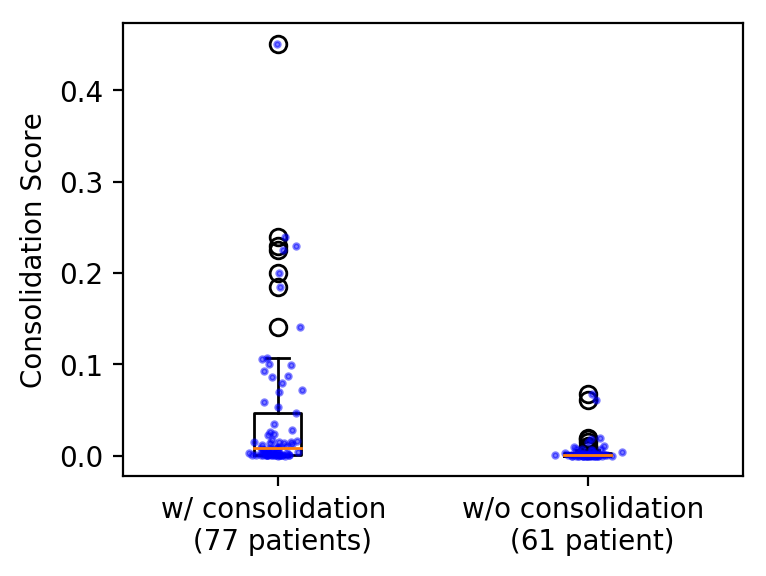

In [29]:
sample_ranks = scipy.stats.rankdata(np.concatenate((cons_frac_cons, cons_frac_ggos)))
_, p1 = scipy.stats.mannwhitneyu(sample_ranks[:len(cons_frac_cons)], sample_ranks[len(cons_frac_cons):])
print(p1)

print (np.mean(cons_frac_cons), np.median(cons_frac_cons), np.std(cons_frac_cons))
print (np.mean(cons_frac_ggos), np.median(cons_frac_ggos), np.std(cons_frac_ggos))

print ('p-value = %g (%d vs. %d)'%(p1, len(cons_frac_cons), len(cons_frac_ggos)))

plt.figure(figsize = [4,3], dpi=200)
src_pts = [cons_frac_cons, cons_frac_ggos]
for i in range(2):
    _ = plt.boxplot(src_pts[i], positions=[i])
    y = src_pts[i]
    x = np.random.normal(i, 0.04, size=len(y))
    plt.plot(x, y, 'bo', alpha=0.5, markersize=2)
plt.ylabel('Consolidation Score')
plt.xlim([-0.5, 1.5])
_ = plt.xticks([0,1], 
               ['w/ consolidation \n (%d patients)'%len(cons_frac_cons), 
                'w/o consolidation \n (%d patient)'%len(cons_frac_ggos)])
# plt.ylim([-0.005,0.1])

In [30]:
# draw auc for classification
frac_cons_roc = frac_cons[has_cons >= 0]
has_cons_roc = has_cons[has_cons >= 0]
th = np.arange(0, 0.005, 0.2)
sense = []
speci = []
for th in np.arange(0, np.max(frac_cons_roc) + 0.005, 0.005):
    pred_roc = np.where(frac_cons_roc > th, 1, 0)
    sense.append(np.sum(pred_roc * has_cons_roc) / np.sum(has_cons_roc, dtype=np.float32))
    speci.append(np.sum((1-pred_roc) * (1-has_cons_roc)) / np.sum(1-has_cons_roc, dtype=np.float32))
sense = np.array(sense)
speci = np.array(speci)

In [31]:
frac_cons_roc_th = frac_cons_th[has_cons >= 0]
has_cons_roc_th = has_cons[has_cons >= 0]
th = np.arange(0, 0.005, 0.2)
sense_th = []
speci_th = []
for th in np.arange(0, np.max(frac_cons_roc_th)+0.005, 0.005):
    pred_roc = np.where(frac_cons_roc_th > th, 1, 0)
    sense_th.append(np.sum(pred_roc * has_cons_roc_th) / np.sum(has_cons_roc_th, dtype=np.float32))
    speci_th.append(np.sum((1-pred_roc) * (1-has_cons_roc_th)) / np.sum(1-has_cons_roc_th, dtype=np.float32))
sense_th = np.array(sense_th)
speci_th = np.array(speci_th)

In [32]:
def roc_curve(sensitivity, specificity, order='increase'):
    tpr = np.copy(sensitivity)
    fpr = 1 - np.copy(specificity)
    
    if not order == 'increase':
        tpr = tpr[::-1]
        fpr = fpr[::-1]
    
    # add points
    pts = [[0, 0]]
    for tp, fp in zip(tpr, fpr):
#         print (tp, fp)
        pts.append([pts[-1][0], fp])
        pts.append([tp, fp])
    pts.append([pts[-1][0], 1])
    
    pts = np.array(pts)
    
    return pts

(-0.01, 1.01)

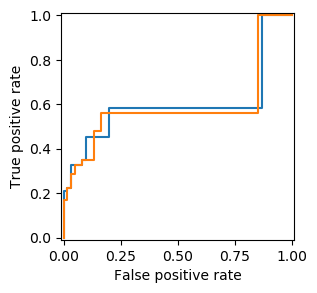

In [33]:
pts = roc_curve(sense, speci, 'decrease')
pts_th = roc_curve(sense_th, speci_th, 'decrease')
plt.figure(figsize=[3,3], dpi=100)
plt.plot(pts[:,1], pts[:,0])
plt.plot(pts_th[:,1], pts_th[:,0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])

In [34]:
print (np.mean(cons_frac_cons), np.std(cons_frac_cons))
auc = np.sum((pts[1:,1] - pts[:-1,1]) * pts[:-1,0])
print (auc)

0.04033107333048631 0.0746691163674843
0.5974025974025974


In [35]:
print (np.mean(cons_frac_cons_th), np.std(cons_frac_cons_th))
auc = np.sum((pts_th[1:,1] - pts_th[:-1,1]) * pts_th[:-1,0])
print (auc)

0.0318466408717258 0.056062234385791096
0.5867575047902917


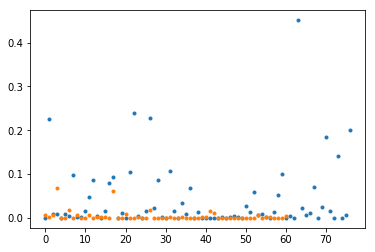

In [36]:
plt.plot(cons_frac_cons, '.')
plt.plot(cons_frac_ggos, '.')

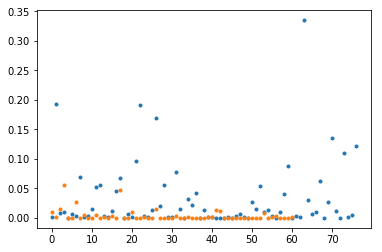

In [37]:
plt.plot(cons_frac_cons_th, '.')
plt.plot(cons_frac_ggos_th, '.')

In [53]:
ind = 1
mrn = mrn_unique[ind]
patient = get_patient_data_mrn(mrn, dataset, patient_infos)
patient['pred_th'] = np.where(patient['pred'] > 0.5, 1, 0)
patient['pred_th'] = np.where(patient['img'][..., [3]] > (1024 - 200) / 110.0, 1, 0) + patient['pred_th']
print (mrn, patient['info'], frac_cons[ind])

0631027_E15457491_4 {'cohort': 'mgh', 'all_types': [1, 4, 6]} 0.005676025480654515


In [54]:
patient['pred'].sum() / patient['lung'].sum()

0.15655187

In [55]:
def blend_ct_with_pred(ct_slice, pred_slice, alpha = 0.25, border = False):
    ct_blend = (ct_slice + 1150) / 1500.0 * 255
    ct_blend[ct_blend < 0] = 0
    ct_blend[ct_blend > 255] = 255
    ct_blend = np.tile(ct_blend, [1,1,3])
    
    if pred_slice is not None:
        mask_img = tf.keras.utils.to_categorical(pred_slice, 3)
        mask_img = mask_img[..., ::-1]
        mask_img[...,-1] = 0
        
        if border:
            alpha = 1
            mask_img[..., 1] = np.where(np.sum(mask_img, -1) > 0, 1, 0)
            mask_img[..., 0] = mask_img[..., 0] - scipy.ndimage.morphology.binary_erosion(mask_img[..., 0], iterations = 2)
            mask_img[..., 1] = mask_img[..., 1] - scipy.ndimage.morphology.binary_erosion(mask_img[..., 1], iterations = 2)
            mask_img[..., 1][mask_img[..., 0] > 0] = 0
        
        if alpha == 1:
            mask_sum = np.where(np.sum(mask_img,-1)>0, 1, 0)
            ct_blend[mask_sum==1, :] = 0
            ct_blend[mask_img == 1] = 255
        else:
            ct_blend = ct_blend * (1 - mask_img * alpha) + np.ones_like(ct_blend) * 255 * mask_img * alpha
    return ct_blend.astype(np.uint8)

def render_ct_img(patient, tag, alpha = 0.25):
    ct = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(args.input_dir, patient['info']['cohort'], 'ct_origin', mrn+'.nii')))
#     ct = scipy.ndimage.zoom(ct, [1,0.5,0.5], order=1)
    ct = ct[:, ::-1, :]
    pred_img = scipy.ndimage.zoom(patient[tag][:, ::-1, :, 0], [1,2,2], order=0)
    label_img = scipy.ndimage.zoom(patient['label'][:, ::-1, :, 0], [1,2,2], order=0)
    offset = patient['islice'][0] + 3
    
    ct_blends = []
    ct_label_blends = []
    
    print (ct.shape[0])
    for islice in range(ct.shape[0]):
        if (islice + 1) % 10 == 0:
            print (islice, end = ',')
        seg_slice = islice - offset
        if seg_slice >= 0 and seg_slice < pred_img.shape[0]:
            ct_blends.append(blend_ct_with_pred(ct[islice, ..., np.newaxis], pred_img[seg_slice, ...], alpha, True))
            ct_label_blends.append(blend_ct_with_pred(ct[islice, ..., np.newaxis], label_img[seg_slice, ...], alpha, True))
        else:
            ct_blends.append(blend_ct_with_pred(ct[islice, ..., np.newaxis], None))
            ct_label_blends.append(blend_ct_with_pred(ct[islice, ..., np.newaxis], None))
    
    return ct_blends, ct_label_blends, ct       

In [56]:
# save png images
# for i, mrn in enumerate(mrn_unique):
#     print ('%d/%d'%(i+1, len(mrn_unique)))
    
#     patient = get_patient_data_mrn(mrn, dataset, patient_infos)
#     cohort = patient['cohort'][0]
    
#     output_dir = os.path.join(args.input_dir, 'all_results', 'display', mrn)
# #     output_dir = os.path.join(args.input_dir, cohort, 'result', 'display', mrn)
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
    
#     ct_display, _ = render_ct_img(patient)
#     for k, img in enumerate(ct_display):
#         imageio.imwrite(os.path.join(output_dir, 'IMAG_%s.png'%str(k+1).zfill(4)), img)

In [57]:
ct_display, ct_label, ct = render_ct_img(patient, 'pred_th')

62
9,19,29,39,49,59,

0631027_E15457491_4


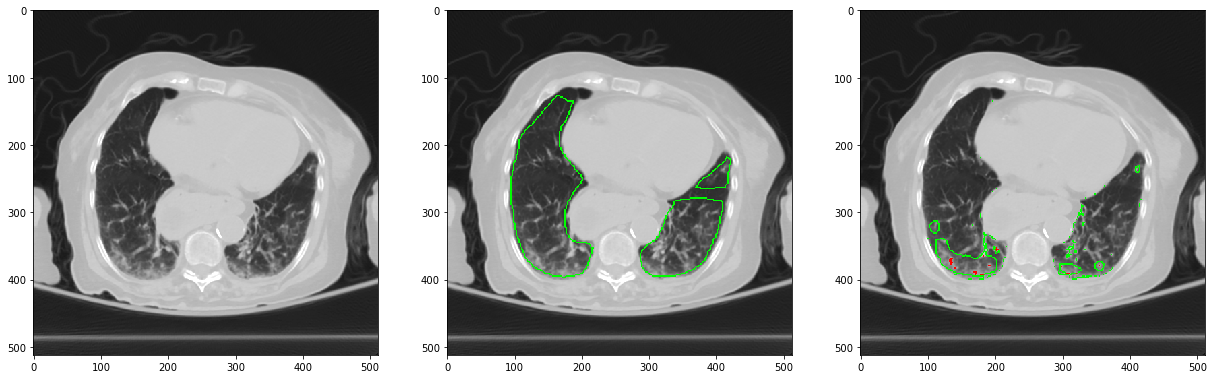

In [58]:
display_slice = 25
print (mrn)
plt.figure(figsize=[21,7])
plt.subplot(131); plt.imshow(ct[display_slice, ...], 'gray', vmin=-1150, vmax=350)
plt.subplot(132); plt.imshow(ct_label[display_slice])
plt.subplot(133); plt.imshow(ct_display[display_slice])

In [115]:
ct_img = ct[display_slice][64:-64, 64:-64]
ct_img = (ct_img + 1150) / 1500.0 * 255
ct_img[ct_img < 0] = 0
ct_img[ct_img > 255] = 255
ct_img = ct_img.astype(np.uint8)
imageio.imwrite('images/internal_%d_%d_ct.png'%(ind, display_slice), ct_img)

In [144]:
imageio.imwrite('images/internal_%d_%d_label.png'%(ind, display_slice), ct_label[display_slice][64:-64, 64:-64, :])
imageio.imwrite('images/internal_%d_%d_th.png'%(ind, display_slice), ct_display[display_slice][64:-64, 64:-64, :])

6026796_E15477693_14


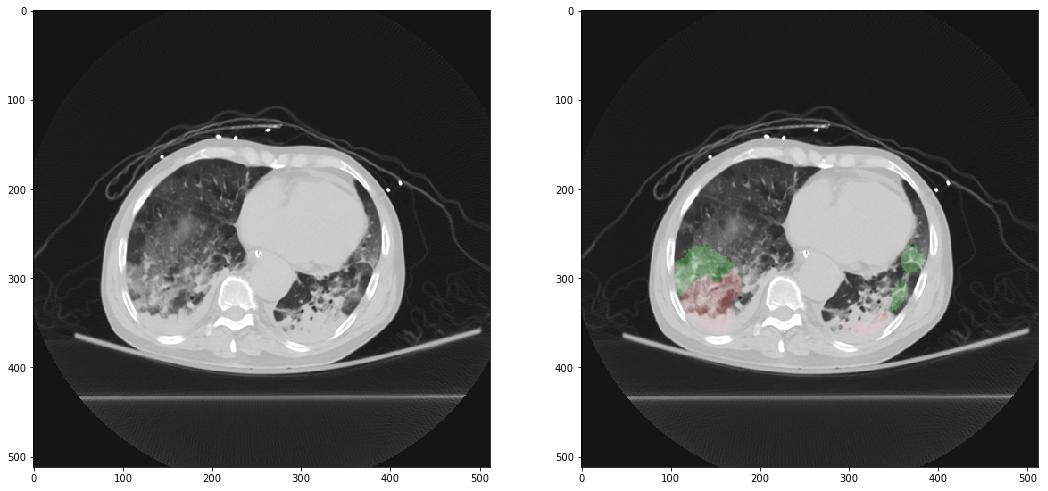

In [59]:
display_slice = 90
print (mrn)
plt.figure(figsize=[18,9])
plt.subplot(121); plt.imshow(ct[display_slice, ...], 'gray', vmin=-1150, vmax=350)
plt.subplot(122); plt.imshow(ct_display[display_slice])